In [1]:
import pandas as pd
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import numpy as np
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt

## Datos:

In [2]:
df = pd.read_csv('day.csv')
df = df.drop(columns = ['casual','registered', 'instant', 'dteday', 'mnth', 'yr' ])
df = pd.get_dummies(df, columns = ['weekday', 'season', 'weathersit'])

## Modelo KNN con 10 vecinos cercanos:

In [3]:
target = 'cnt'
y = df[target]
X = df.copy()
X = X.drop(target, axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

model = KNeighborsRegressor(n_neighbors = 10).fit(X_train_scaled, y_train)
predicciones = model.predict(X_test_scaled)
r2_score(y_pred=predicciones, y_true=y_test)

0.4553141044751985

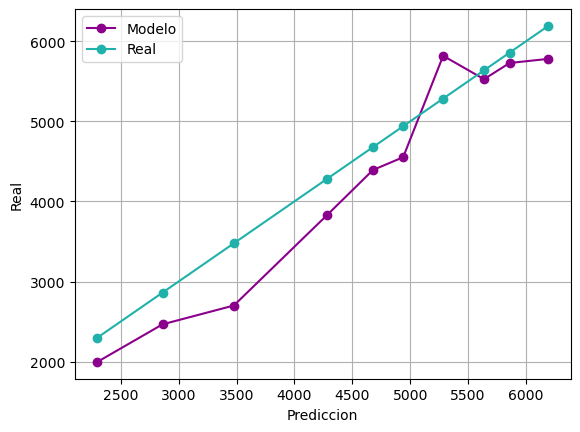

In [4]:
def calibracion(predicciones, y, bins):
    df_calibracion = pd.DataFrame({
        'predicciones': predicciones,
        'y': y
    })
    
    df_calibracion['bins'] = pd.qcut(df_calibracion['predicciones'], q=bins, labels=False) + 1
    gropuped = df_calibracion.groupby('bins').mean()
    
    plt.plot(gropuped.predicciones, gropuped.y, label="Modelo", marker="o", color = "darkmagenta")
    plt.plot(gropuped.predicciones, gropuped.predicciones, label="Real", marker="o", color = "lightseagreen")
    plt.grid()
    plt.legend()
    plt.xlabel("Prediccion")
    plt.ylabel("Real")
    
calibracion(predicciones, y_test, bins = 10)

### Análisis:

- Al utilizar 10 vecinos cercanos en el modelo KNN, podemos ver que obtenemos un valor de R2 de 0.4553. Esto significa que este modelo explica el 45.53% de la variación de los datos. Con la gráfica anterior, se puede ver como el modelo no se ajusta correctamente a los datos reales, ya que existen caídas y subidas en los datos que no coinciden con el modelo. Aunque este porcentaje de R2 no es el peor, definitivamente es un valor que se puede mejorar utilizando el número óptimo de vecinos. 

## Encontrar número óptimo de vecinos:

In [5]:
nn = []
r2 = []
r2_train = []
for i in range(1, 60):
    nn.append(i)
    model = KNeighborsRegressor(n_neighbors=i).fit(X_train_scaled, y_train)
    predicciones = model.predict(X_test_scaled)
    r2.append(r2_score(y_pred=predicciones, y_true=y_test))
    predicciones_train = model.predict(X_train_scaled)
    r2_train.append(r2_score(y_pred = predicciones_train, y_true = y_train))

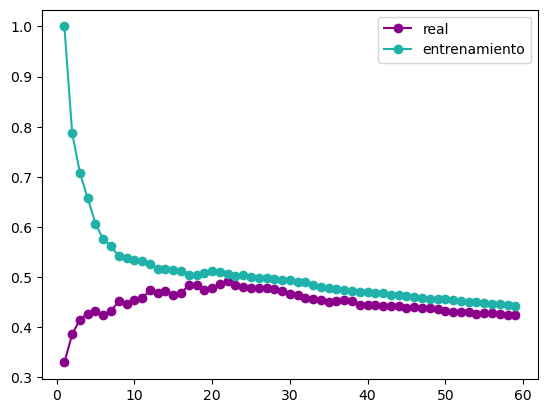

In [6]:
resultados = pd.DataFrame({
    'nn': nn,
    'r2': r2,
    'r2_train': r2_train
})

plt.plot(resultados.nn, resultados.r2, marker = "o", label = "real", color = "darkmagenta")
plt.plot(resultados.nn, resultados.r2_train, marker = "o", label = "entrenamiento", color = "lightseagreen")
plt.legend()

In [7]:
resultados.head()

,nn,r2,r2_train
0,1,0.329788,1.000000
1,2,0.386437,0.787319
2,3,0.415432,0.708195
3,4,0.426956,0.657194
4,5,0.432548,0.606979


In [8]:
óptimo = resultados.loc[resultados['r2'].idxmax()]

print("El valor de nn con el mayor r2 es:", óptimo['nn'])
print("El valor máximo de r2 es:", óptimo['r2'])

El valor de nn con el mayor r2 es: 22.0
El valor máximo de r2 es: 0.4930925241585855


## Modelo KNN con el número óptimo de vecinos cercanos:

In [9]:
model = KNeighborsRegressor(n_neighbors=22).fit(X_train_scaled, y_train)
predicciones = model.predict(X_test_scaled)
r2_score(y_pred=predicciones, y_true=y_test)

0.4930925241585855

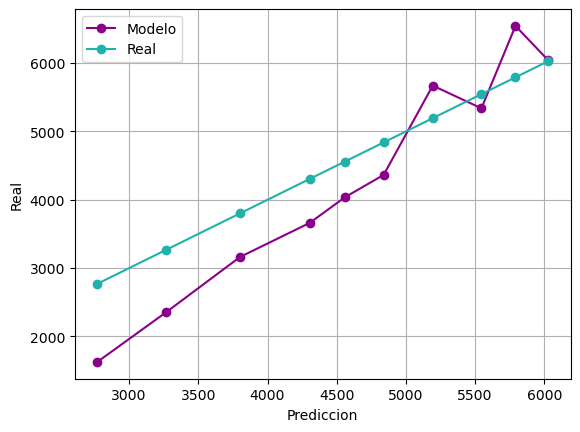

In [10]:
calibracion(predicciones, y_test, bins = 10)

### Análisis:

- Al utilizar una cantidad de 22 vecinos cercanos, el cual es el número óptimo, podemos ver que existe un aumento en el valor del R2 en comparación al modelo anterior. El R2 ahora es de 0.4931, es decir 49.31% de la variación de los datos se explica con el modelo KNN. Aunque el aumento en la precisión es evidente, definitivamente aún no es el modelo más eficiente, ya que aun no se ajusta correctamente el modelo a los datos reales. 